# Customer Segmentation using Recency, Frequency and Monetary (RFM) Value 

In [14]:
import pandas as pd
import csv
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# the following code loads the dataframe and calculates the RFM for each customer
# Code is adopted from https://practicaldatascience.co.uk/machine-learning/how-to-use-knee-point-detection-in-k-means-clustering


data = pd.read_csv("data.csv")
data['Date']=pd.to_datetime(data['Date'].astype(str), format='%Y-%m-%d')
data['Total']= data['Total'].astype(float)
df = data
end_date = max(df['Date']) + dt.timedelta(days=1)

df_rfm = df.groupby('Customer').agg(
    recency=('Date', lambda x: (end_date - x.max()).days),
    monetary=('Total', 'sum'))

df_rfm["frequency"] = df.groupby('Customer').agg({'Date': pd.Series.nunique})

df_rfm.reset_index()
df_rfm.sort_values("monetary", ascending = False)


,recency,monetary,frequency
Customer,,,
c861aaeb3de94a52a00e94307b2cbb1d7af747a7f558aa0e7cc229afe0643569,2,1909.8,109
f88141468958d0757b03556a2b80c335b694cacac95742748f6115aba5ae79b4,3,1278.8,29
b2ed6d63fe93443a19987ae99e05514d45101100230db69a0b5527b160bd6406,9,1200.7,90
83705a5dba3b5a82bd286dee85d91985557ad730db1e920a877e3d4adff7fced,3,1009.8,58
c177bae70c4b8087e2ada413e7b77644cba0d2398e50657a97946156c63de677,6,908.8,67
...,...,...,...
486bdd076dcd19389eadb09c5bcc0618d41cb428651604fa2b8666e4fac156c5,74,0.0,1
2378bdd2cf4f491cf401e6b215cbb4fdfec6f76b21801d6bcd3cad070abb156c,214,0.0,1
e0a572040c1d7aae885b30393d52a7b50b1695d7780bc15db782586abc03be90,107,0.0,1


# Kmeans Clustering of the Customers

In [8]:
# preprocessing for Kmeans functions credit to https://practicaldatascience.co.uk/machine-learning/how-to-use-knee-point-detection-in-k-means-clustering

def preprocess(df):
    """Preprocess data for KMeans clustering"""
    
    scaler = StandardScaler()
    scaler.fit(df)
    df_norm = scaler.transform(df)
    
    return df_norm

In [12]:
def elbow_plot(df):
    """Create elbow plot from normalized data"""
    
    df_norm = preprocess(df)
    
    sse = {}
    
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df_norm)
        sse[k] = kmeans.inertia_
    
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.set()
    sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()

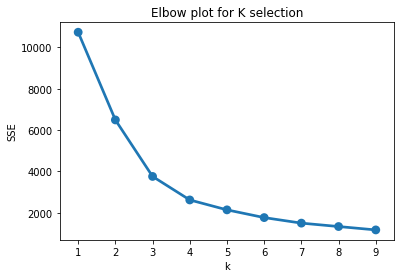

In [15]:
elbow_plot(df_rfm)

## From the knee plot and from domain knowledge of customer analytics, we choose four clusters for the customers

In [16]:
def run_kmeans(df, k):
    """Run KMeans clustering, including 
    #input: 
    ------
    df: rfm pandas dataframe
    k: Number of clusters to assign 
    """
    
    df_norm = preprocess(df)

    kmeans = KMeans(n_clusters=k, 
                    random_state=1)
    kmeans.fit(df_norm)
    return df.assign(cluster=kmeans.labels_)

In [40]:
# run kmeans and assign the clusters

clusters = run_kmeans(df_rfm,4)
clusters.groupby('cluster').agg(
    recency=('recency','mean'),
    frequency=('frequency','mean'),
    monetary=('monetary','mean'),
    cluster_size=('monetary','count')
).round(1).sort_values(by='monetary', ascending = False)

,recency,frequency,monetary,cluster_size
cluster,,,,
0,13.7,48.2,720.2,31
3,59.7,16.7,220.1,261
1,127.0,2.8,32.6,1754
2,529.0,1.6,19.1,1533


In [45]:
# assign cluster names and reset index

segments_dictionary = {0: "1", 3: "2", 1: "3", 2: "4"}
clusters["segment"] = clusters["cluster"].map(segments_dictionary)
customer_segments = clusters.reset_index()
customer_segments.to_csv("segments.csv")
customer_segments.head()

,Customer,recency,monetary,frequency,cluster,segment
0,0025cc04d23e13a351d847f597cf61a09a5dc9cece7a6e...,239,17.0,1,1,3
1,002f03d7613e850bbe6f6f266b5aea1145a02c3fed7f83...,240,8.0,1,1,3
2,003a0fa4defb64752e1b95055f6dab1d8d663e03260db6...,28,39.0,3,1,3
3,004d2932822812e34c826a2e465215263a3ce375ebae66...,112,17.0,1,1,3
4,005864dd0d6360d6d1c3346b3f07b1557583ed53900ee6...,700,6.0,1,2,4


In [53]:
customer_segments.groupby('segment').agg(
    recency_mean=('recency','mean'),
    frequency_mean=('frequency','mean'),
    monetary_mean=('monetary','mean'),
    cluster_size=('Customer','count')
).round(1).sort_values(by='monetary_mean', ascending = False)

,recency_mean,frequency_mean,monetary_mean,cluster_size
segment,,,,
1,13.7,48.2,720.2,31
2,59.7,16.7,220.1,261
3,127.0,2.8,32.6,1754
4,529.0,1.6,19.1,1533


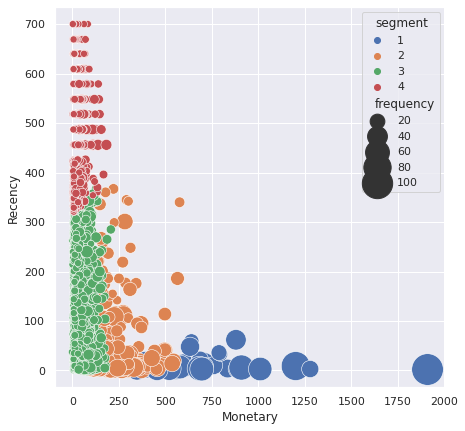

In [46]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set()
sns.scatterplot(data= customer_segments.sort_values("segment"), x= "monetary", y = "recency", size = "frequency", sizes = (50,1000), hue= "segment")
plt.xlabel("Monetary")
plt.ylabel("Recency")
plt.savefig("images/segments.png")